# Setup

In [1]:
# Importing COCO instance json
from utils.DataLoader import import_data
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import uuid
import os

# Specifying desired categories
CATEGORIES = ["car", "bicycle", "person"]


## Prerequisites

In [7]:
# Needed pahts
WORKING_DIRECTORY = os.getcwd()
DATA_FOLDER = os.path.join(WORKING_DIRECTORY, 'dependencies', 'yolo_data', 'coco2017')
OUTPUT_FOLDER = os.path.join(WORKING_DIRECTORY, 'dependencies', 'cnn_data', 'training')

# Specifying desired categories
CATEGORIES = ["car", "bicycle", "person"]


# Extracting data for model

Use this to setup environment

In [8]:
# Extract data using import data function
data = import_data(DATA_FOLDER, file_name = 'instances_train2017.json')

In [11]:
# Generate annotations dataframe
def generate_annot_df(bunch, cats):
    
    # Filename and URL
    dic = {x['id']: x['file_name'] for x in bunch.images}
    url = {x['id']: x['coco_url'] for x in bunch.images}
    
    # Extract id for categories
    category_ids = {cat['id']: cat['name'] for cat in bunch.catagories if cat['name'] in cats}
    
    
    df = pd.DataFrame(bunch.annotations)
    
    # Removing images of crowds
    df = df[-df.image_id.isin(df[df.iscrowd == 1].image_id.to_list())][['image_id', 'area', 'bbox', 'category_id']]
    
    # Adding file name to datafram
    df['file_name'] = df['image_id'].map(dic)
    
    # Adding coco url needed for extraction
    df['coco_url'] = df['image_id'].map(url)

    # Unpacking bounding box column
    df = df.assign(
        x_min = lambda x: x['bbox'].apply(lambda x: x[0]),
        y_min = lambda x: x['bbox'].apply(lambda x: x[1]),
        w =lambda x: x['bbox'].apply(lambda x: x[2]),
        h =lambda x: x['bbox'].apply(lambda x: x[3]),
        x_max = lambda x: x.x_min + x.w,
        y_max = lambda x: x.y_min + x.h)
    
    # Resetting index and dropping all annotations outside of desired list of categories
    df = df.reset_index(drop=True)
    df = df[df.category_id.isin(category_ids.keys())][['file_name', 'coco_url', 'image_id', 'category_id', 'area','bbox', 'x_min', 'y_min', 'x_max', 'y_max']]
    
    # Creating new category ids (so that they are not 2, 5 , 7, and instead, 0, 1, 2)
    categories = {old: new for (new, old) in zip(range(len(category_ids.keys())), category_ids.keys())}
    
    # Get category names and add to dataframe
    category_names = {value: category_ids[key] for key, value in categories.items()}
    df.category_id = df.category_id.map(categories)
    df['category_name'] = df.category_id.map(category_names)

    return df, category_names

In [12]:
training_annot, category_names = generate_annot_df(data, CATEGORIES)
#del data # Removing data dict to not take up too much ram

In [21]:
i = ['hello']

In [22]:
if i:
    print(True)
else:
    print(False)

True


In [14]:
def fetch_crop_and_save_image(annot_df, output_folder, number_of_images_per_category=1000, images_to_exclue = None):
    
    # Categories we want [reduced for simplicity]
    cats = ['person', 'car', 'bicycle']
    
    # Creating directories to store images (TensorFlow can infer labels from directory structure)
    for cat in cats:
        if not os.path.exists(os.path.join(output_folder, cat)): os.makedirs(os.path.join(output_folder, cat))
    
    if images_to_exclue:
    # Subsetting annot_df to equally distributes categories (1000 per category)
    annot_df = annot_df[annot_df.category_name.isin(cats)].sort_values(by='area', ascending = False).groupby('category_id').apply(lambda x: x[:number_of_images_per_category]).reset_index(drop=True)
    
    
    print(f'Cropping and moving: {len(annot_df)} images')
    images_done = 0
    
    #New image size
    new_size = (250, 250)
    
    
    # looping through dataset to crop images according to category
    for ind, row in annot_df.iterrows():
        images_done += 1

        # Fetching image contents
        response = requests.get(row.coco_url)
        
        # Cropping images based on bbox
        (left, top, right, bottom) = row.x_min, row.y_min, row.x_max, row.y_max
        
        # Create uuid for naming (only using the first part of the uuid), to use for renaming
        uid =  str(uuid.uuid4()).split('-')[0]
        
        # Extract, transform and load images into new folder
        with Image.open(BytesIO(response.content)) as img:
            img = img.crop((left, top, right, bottom))
            img = img.resize(new_size)
            img.save(f'{os.path.join(output_folder, row.category_name)}/{row.category_name}_{uid}.jpg')
        
        print(f'Images done: {images_done}/{len(annot_df)}')

In [ ]:
fetch_crop_and_save_image(training_annot, OUTPUT_FOLDER)

Cropping and moving: 3000 images
Images done: 1/3000
Images done: 2/3000
Images done: 3/3000
Images done: 4/3000
Images done: 5/3000
Images done: 6/3000
Images done: 7/3000
Images done: 8/3000
Images done: 9/3000
Images done: 10/3000
Images done: 11/3000
Images done: 12/3000
Images done: 13/3000
Images done: 14/3000
Images done: 15/3000
Images done: 16/3000
Images done: 17/3000
Images done: 18/3000
Images done: 19/3000
Images done: 20/3000
Images done: 21/3000
Images done: 22/3000
Images done: 23/3000
Images done: 24/3000
Images done: 25/3000
Images done: 26/3000
Images done: 27/3000
Images done: 28/3000
Images done: 29/3000
Images done: 30/3000
Images done: 31/3000
Images done: 32/3000
Images done: 33/3000
Images done: 34/3000
Images done: 35/3000
Images done: 36/3000
Images done: 37/3000
Images done: 38/3000
Images done: 39/3000
Images done: 40/3000
Images done: 41/3000
Images done: 42/3000
Images done: 43/3000
Images done: 44/3000
Images done: 45/3000
Images done: 46/3000
Images don

# Library import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import os
import pandas as pd
import numpy as np
import random
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import random
import torch
import torchvision
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'


2023-05-17 10:22:45.308738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f'Using {"gpu" if device == "cuda" else "cpu"}')

Using cpu


# TensorFlow

In [3]:
# Specifying relevant paths
WORKING_DIRECTORY = os.getcwd()
DEPENDENCIES = os.path.join(WORKING_DIRECTORY, 'dependencies')
MODELS = os.path.join(DEPENDENCIES, 'models')
TRAINING = os.path.join(DEPENDENCIES, 'cnn_data', 'training')

In [5]:
# Generating image dataset from directory
img_height, img_width = 250, 250
train, val = tf.keras.utils.image_dataset_from_directory(
    TRAINING,
    labels='inferred',
    color_mode='rgb',
    seed=42,
    batch_size=32,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='both'
)

# class names
class_names = train.class_names

Found 3090 files belonging to 3 classes.
Using 2472 files for training.
Using 618 files for validation.
Metal device set to: AMD Radeon Pro 5300M

systemMemory: 32.00 GB
maxCacheSize: 1.99 GB



2023-05-17 10:23:44.525108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-17 10:23:44.525181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
print(f'Class names: {class_names}')

Class names: ['bicycle', 'car', 'person']


### Image Processing

In [22]:
# We won't resize or rescale as that is the first layer of our nn

# Augmenting images with flipping and rotation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])
train_aug = train.map(lambda x, y: (data_augmentation(x), y))
val_aug = val.map(lambda x, y: (data_augmentation(x), y))


train_concat = train.concatenate(train_aug)
val_concat = val.concatenate(val_aug)

train_concat = train_concat.shuffle(buffer_size = 10) 
val_concat = val_concat.shuffle(buffer_size = 10) 


In [24]:
for image_batch, labels_batch in val_concat:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


### CNN Based on Tiny VGG (From CNN Explainer)

In [41]:
vgg = keras.Sequential([
    layers.Resizing(125,125),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(32, 3, strides=2, padding="same"), # conv_1_1
    layers.Activation("relu"), # relu_1_1
    layers.Conv2D(32, 3, strides=2, padding="same"), # conv_1_2
    layers.Activation("relu"), # relu_1_2
    layers.MaxPool2D(3, strides = 2, padding="same"), # max_pool_1
    layers.Conv2D(32, 3, strides=2, padding="same"), # conv_2_1
    layers.Activation("relu"), # relu_2_1
    layers.Conv2D(32, 3, strides=2, padding="same"), # conv_2_2
    layers.Activation("relu"), # relu_2_2
    layers.MaxPool2D(3, strides = 2, padding="same"), # max_pool_2
    layers.Flatten(),
    layers.Dense(3)    
])

In [42]:
# Compiling model using sgd optimizer, cross entropy as loss and accuracy metric
vgg.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Add callbacks with early stopping if after 10 epochs nothing change + reducing lr with 0.1 after 5 epochs if nothing improves
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
             keras.callbacks.ModelCheckpoint("vgg_{epoch}.keras", save_freq=5),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)]

In [43]:
# Training model using 100 epochs (batch size is 32)
epochs = 100


vgg_history = vgg.fit(train_concat,
                      epochs=epochs,
                      callbacks=callbacks,
                      validation_data=val_concat)

Epoch 1/100
156/156 [==============================] - 36s 219ms/step - loss: 1.1941 - accuracy: 0.3218 - val_loss: 1.0986 - val_accuracy: 0.3371 - lr: 0.0100
Epoch 2/100
156/156 [==============================] - 37s 231ms/step - loss: 1.0986 - accuracy: 0.3226 - val_loss: 1.0986 - val_accuracy: 0.3371 - lr: 0.0100
Epoch 3/100
156/156 [==============================] - 35s 219ms/step - loss: 1.0986 - accuracy: 0.3224 - val_loss: 1.0986 - val_accuracy: 0.3371 - lr: 0.0100
Epoch 4/100
156/156 [==============================] - 39s 246ms/step - loss: 1.0986 - accuracy: 0.3226 - val_loss: 1.0986 - val_accuracy: 0.3371 - lr: 0.0100
Epoch 5/100
156/156 [==============================] - 35s 220ms/step - loss: 1.0986 - accuracy: 0.3226 - val_loss: 1.0986 - val_accuracy: 0.3371 - lr: 0.0100
Epoch 6/100
156/156 [==============================] - 39s 246ms/step - loss: 1.0986 - accuracy: 0.3224 - val_loss: 1.0986 - val_accuracy: 0.3371 - lr: 0.0100
Epoch 7/100
156/156 [=========================

In [52]:
vgg.save(f'{image_folder}/TinyVGG_Model.keras')

### Keras's small version of Xception network

In [33]:
# Inspired by keras smaller version of the XCeption network
def XceptionModel(input_shape=(250,250,3), num_of_classes=3):
  
  # Input layer of model
  input_layer = keras.Input(shape=input_shape)

  # Added rescaling and resizing to input
  lay = layers.Resizing(125,125)(input_layer)
  lay = layers.Rescaling(1.0 / 255)(lay)

  # First con-block
  lay = layers.Conv2D(128, 3, strides=2, padding="same")(lay)
  lay = layers.BatchNormalization()(lay)
  lay = layers.Activation("relu")(lay)

  previous_residuals = lay

  for filter in [128, 256, 512]:
    lay = layers.Activation("relu")(lay)
    lay = layers.SeparableConv2D(filter, 3, padding="same")(lay)
    lay = layers.BatchNormalization()(lay)
    lay = layers.Activation("relu")(lay)
    lay = layers.SeparableConv2D(filter, 3, padding="same")(lay)
    lay = layers.BatchNormalization()(lay)
    lay = layers.MaxPooling2D(3, strides = 2, padding="same")(lay)

    residual = layers.Conv2D(filter, 1, strides=2, padding="same")(previous_residuals)
  
    lay = layers.add([lay, residual])
    previous_residuals = lay

  lay = layers.SeparableConv2D(1024, 3, padding="same")(lay)
  lay = layers.BatchNormalization()(lay)
  lay = layers.Activation("relu")(lay)

  lay = layers.GlobalAveragePooling2D()(lay)
  lay = layers.Dropout(0.5)(lay)
  outputs = layers.Dense(num_of_classes, activation='softmax')(lay)

  return keras.Model(input_layer, outputs)

In [34]:
Xception = XceptionModel()

In [35]:
epochs = 100

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras", save_freq=5),
             keras.callbacks.EarlyStopping(monitor='loss', patience=10),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
]

Xception.compile(
    optimizer=keras.optimizers.SGD(0.1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

Xception_history = Xception.fit(train_concat,
                                epochs=epochs,
                                callbacks=callbacks,
                                validation_data=val_concat)

Epoch 1/100
156/156 [==============================] - 50s 284ms/step - loss: 1.5336 - accuracy: 0.5588 - val_loss: 1.0970 - val_accuracy: 0.3766 - lr: 0.1000
Epoch 2/100
156/156 [==============================] - 43s 269ms/step - loss: 0.9106 - accuracy: 0.6683 - val_loss: 1.1713 - val_accuracy: 0.3556 - lr: 0.1000
Epoch 3/100
156/156 [==============================] - 43s 269ms/step - loss: 0.8376 - accuracy: 0.6867 - val_loss: 1.0425 - val_accuracy: 0.5250 - lr: 0.1000
Epoch 4/100
156/156 [==============================] - 42s 267ms/step - loss: 0.7753 - accuracy: 0.7135 - val_loss: 1.1401 - val_accuracy: 0.4895 - lr: 0.1000
Epoch 5/100
156/156 [==============================] - 45s 286ms/step - loss: 0.7122 - accuracy: 0.7265 - val_loss: 1.1763 - val_accuracy: 0.6169 - lr: 0.1000
Epoch 6/100
156/156 [==============================] - 42s 267ms/step - loss: 0.6604 - accuracy: 0.7471 - val_loss: 0.7083 - val_accuracy: 0.7548 - lr: 0.1000
Epoch 7/100
156/156 [=========================

In [37]:
Xception.save(f'{image_folder}/Xception_model_v2.keras')

#### Model Stopped After 46 Epochs due to early stopping

## Plotting Results

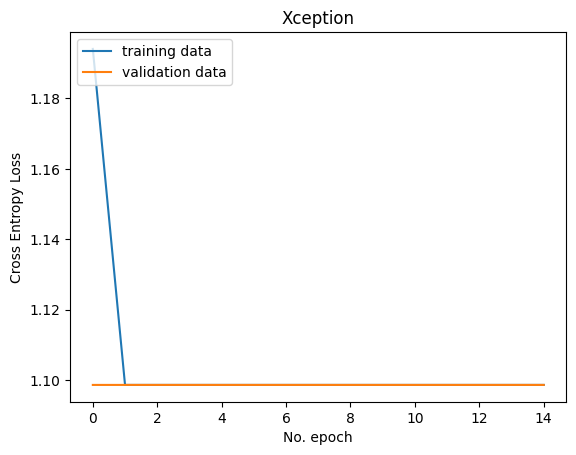

In [46]:
# Plot history:
plt.plot(vgg_history.history['loss'], label='training data')
plt.plot(vgg_history.history['val_loss'], label='validation data')
plt.ylabel('Spatial Cross Entropy Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Tiny VGG')
plt.show()

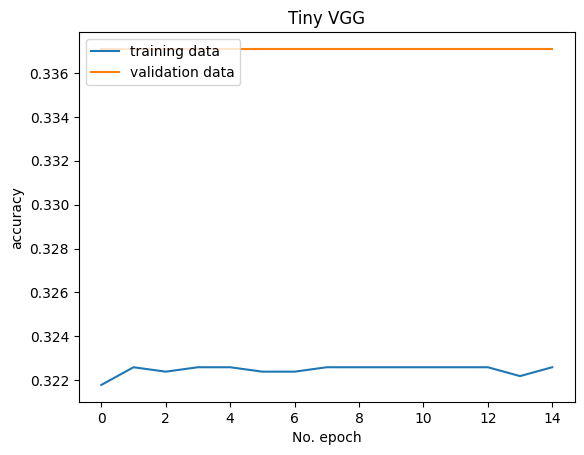

In [53]:
# Plot history:
plt.plot(vgg_history.history['accuracy'], label='training data')
plt.plot(vgg_history.history['val_accuracy'], label='validation data')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Tiny VGG')
plt.show()

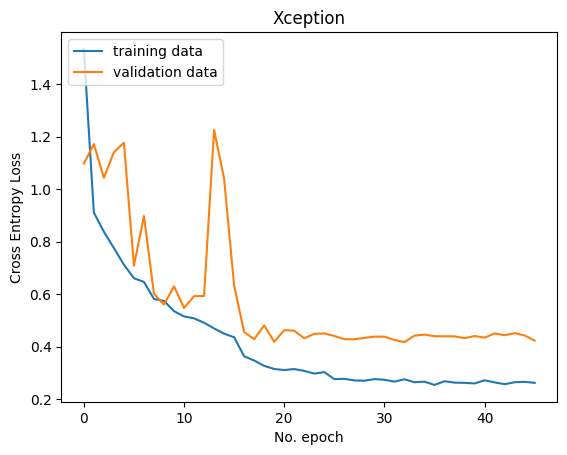

In [40]:
# Plot history:
plt.plot(Xception_history.history['loss'], label='training data')
plt.plot(Xception_history.history['val_loss'], label='validation data')
plt.ylabel('Spatial Cross Entropy Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Xception')
plt.show()

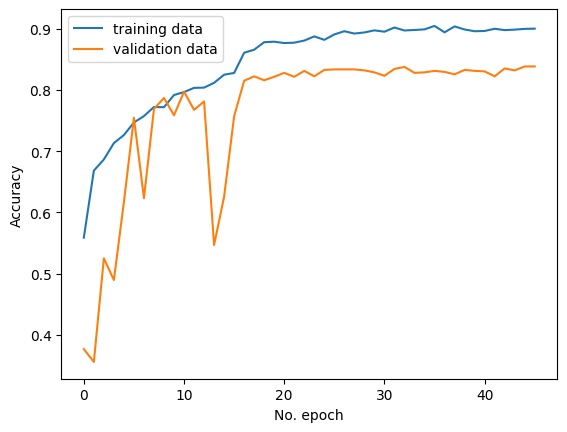

In [39]:
# Plot history:
plt.plot(Xception_history.history['accuracy'], label='training data')
plt.plot(Xception_history.history['val_accuracy'], label='validation data')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title('Xception')
plt.show()